In [1]:
from jrieke import interpretation
from jrieke.utils import load_nifti
import model as models
import torch
from innvestigator import InnvestigateModel
from copy import deepcopy
from jrieke import interpretation
import jrieke.utils as utils
import matplotlib.colors as mcolors
from random import randrange
import pandas as pd

import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from settings import settings
from utils import load_data
from nmm_mask_areas import short_name_map
for k in settings.keys():
    print("Adding " + k + " to namespace")
    globals()[k] = settings[k]

Adding model_path to namespace
Adding data_path to namespace
Adding ADNI_DIR to namespace
Adding train_h5 to namespace
Adding val_h5 to namespace
Adding holdout_h5 to namespace
Adding binary_brain_mask to namespace
Adding nmm_mask_path to namespace
Adding nmm_mask_path_scaled to namespace


In [2]:
with open('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/results/results_final/LRP_heatmaps_AD.pkl', 'rb') as f:
    data_AD = pickle.load(f)
    
with open('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/results/results_final/LRP_heatmaps_HC.pkl', 'rb') as f:
    data_HC = pickle.load(f)

In [3]:
idx_AD = [i[0] for i in data_AD]
idx_HC = [i[0] for i in data_HC]

#### Load results from evaluation notebook

In [4]:
cases = ["AD", "HC", "TP", "TN", "FP", "FN"]

mean_maps_LRP = dict()
rs_per_area_LRP = dict()
for case in cases:
    mean_maps_LRP[case] = load_nifti(os.path.join(data_path, "LRP_{case}.nii".format(case=case)))
    with open(os.path.join(data_path, "LRP_area_evdcs_{case}.pkl".format(case=case)), 'rb') as file:
        rs_per_area_LRP[case] = pickle.load(file)

nmm_mask = load_nifti(nmm_mask_path_scaled)
with open(os.path.join(data_path, 'area_sizes.pkl'), 'rb') as file:
    area_sizes = pickle.load(file)
    
ad_score_list = np.loadtxt(os.path.join(data_path, "ad_scores.txt"))

#### Load test dataset for individual brains

In [5]:
import h5py

In [6]:
def min_max_normalization(subset):
    for i in range(len(subset)):
        subset[i] -= np.min(subset[i])
        subset[i] /= np.max(subset[i])
    return subset
    
def load_data(skip_train=True, skip_val=True, skip_test=False, dtype=np.float32):
    """ Load hdf5 files and extract columns. """
    X_train, y_train, X_val, y_val, X_holdout, y_holdout = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    # train
    if not skip_train:
        train_h5_ = h5py.File(train_h5, 'r')
        X_train, y_train = train_h5_['X'], train_h5_['y']
        X_train = np.expand_dims(np.array(X_train, dtype=dtype), 1)
        X_train = min_max_normalization(X_train)
        y_train = np.array(y_train)
        print("Total training set length: {}".format(len(y_train)))
        print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
        print("Number of AD patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))
    if not skip_val:
        # val
        val_h5_ = h5py.File(val_h5, 'r')
        X_val, y_val = val_h5_['X'], val_h5_['y']
        X_val = np.expand_dims(np.array(X_val, dtype=dtype), 1)
        X_val = min_max_normalization(X_val)
        y_val = np.array(y_val)
        print("Total validation set length: {}".format(len(y_val)))
    if not skip_test:
        # test
        holdout_h5_ = h5py.File(holdout_h5, 'r')
        X_holdout, y_holdout = holdout_h5_['X'], holdout_h5_['y']
        X_holdout = np.expand_dims(np.array(X_holdout, dtype=dtype), 1)
        X_holdout = min_max_normalization(X_holdout)
        y_holdout = np.array(y_holdout)
        print("Total test set length: {}".format(len(y_holdout)))
   
    return X_train, y_train, X_val, y_val, X_holdout, y_holdout


In [7]:
X_train, y_train, X_val, y_val, X_holdout, y_holdout = load_data()

Total test set length: 1220


# Plotting brain maps

In [8]:
shape = mean_maps_LRP["AD"].shape

### Getting contours for areas

In [9]:
from nmm_mask_areas import all_areas

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_colors = [name for hsv, name in by_hsv]
contour_configs = {name: (mini, maxi, cname) for (name, (mini, maxi)), cname in zip(all_areas.items(), sorted_colors[::2])}
contours = {k:None for k in contour_configs.keys()}
for key, (mini, maxi, col) in contour_configs.items():
    tmp_map = np.zeros_like(nmm_mask)
    tmp_map[np.logical_and(nmm_mask>=mini, nmm_mask<=maxi) ] = 40
    contours[key] = tmp_map


## Plotting functions

In [10]:
def plot_contours(areas, x_idx, y_idx, z_idx, c, fig=None, ax=None):
    
    if not areas:
        return
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, figsize=(12, 12))

    for c_ , name in zip(c, areas):

        cmap_area = mcolors.LinearSegmentedColormap.from_list(
            name="colored", colors=[(0,0,0,0), c_], N=100)
        cmap_area_border_b = mcolors.LinearSegmentedColormap.from_list(
            name="black", colors=[(0,0,0,0), "black"], N=100)
        cmap_area_border_w = mcolors.LinearSegmentedColormap.from_list(
            name="white", colors=[(0,0,0,0), "white"], N=100)
        slice_area = contours[name][x_idx, y_idx, z_idx].T
        
        cs_ad = ax.contour(slice_area, [0, 10], cmap=cmap_area_border_b, linewidths=2.5, alpha=1, bordercolors="black")

        cs_ad = ax.contour(slice_area, [0, 10], cmap=cmap_area, linewidths=2, alpha=1, bordercolors="black",
                           
                          label= " ".join(areas))


In [11]:
def plot_idv_brain(heat_map, brain_img, ref_scale, fig=None, ax=None, contour_areas=[],
                  x_idx=slice(0, shape[0]), y_idx=slice(0, shape[1]), z_idx=slice(0, shape[2]),
                  vmin=90, vmax=99.5, set_nan=True, cmap=None, c=None):

    if fig is None or ax is None:
        fig, ax = plt.subplots(1, figsize=(12, 12))
    
    img = deepcopy(heat_map)
    if set_nan:
        img[nmm_mask==0]=np.nan
    if cmap is None:
        cmap = mcolors.LinearSegmentedColormap.from_list(name='alphared',
                                                  colors=[(1, 0, 0, 0),
                                                         "darkred", "red", "darkorange", "orange", "yellow"],
                                                  N=5000)
        
    if brain_img is not None:
        ax.imshow(brain[x_idx, y_idx, z_idx].T, cmap="gray",
                 vmin=grey_vmin, vmax=grey_vmax, alpha=.45)

    vmin, vmax = np.percentile(ref_scale, vmin), np.percentile(ref_scale, vmax)
    im = ax.imshow(img[x_idx, y_idx, z_idx].T, cmap=cmap, 
               vmin=vmin, vmax=vmax, interpolation="gaussian")
    
   
    ax.axis('off')    

    plot_contours(contour_areas, x_idx, y_idx, z_idx, fig=fig, ax=ax, c=c)
    plt.gca().invert_yaxis()
    return fig, ax, im


## Individual maps

In [12]:
patientA = randrange(len(idx_AD))
patientB = randrange(len(idx_HC))

brain_A, brain_B = X_holdout[patientA][0], X_holdout[patientB][0]
grey_vmin, grey_vmax = np.min([brain_A, brain_B]), np.max([brain_A, brain_B])

LRP_map_patient_A = data_AD[patientA][1]
LRP_map_patient_B = data_HC[patientB][1]

##### Define brain slices

In [13]:
first_slice= 57
first_areas = ["Hippocampus", "Temporal pole",
               "Amygdala", "MTG", "Parahippocampal gyrus"]
second_slice= 66
second_areas = first_areas
third_slice= 88
third_areas = ["MTG", "STG", "Frontal pole", "TrIFG"]

# Colors for areas slice 1 & 2
cs = ["linen", "blue", "cyan", "lime", "hotpink"]
# Colors for slice 3
cs_3 = ["grey", "black", "white", "lime"]

# Plotting

/home/celine/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'bordercolors'
  s)
/home/celine/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'bordercolors', 'label'
  s)
/home/celine/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


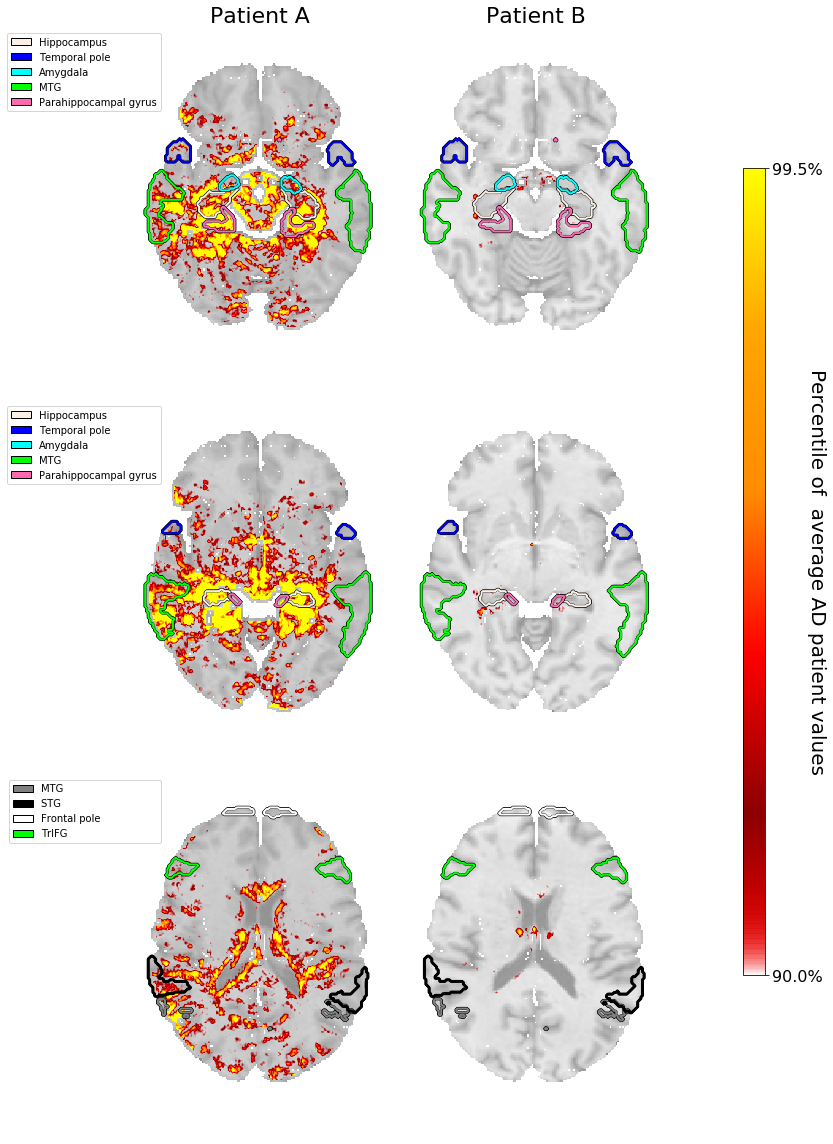

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=(12, 16), sharey=True)

brain = deepcopy(brain_A)
brain[nmm_mask==0] = np.nan
vmin, vmax = 90, 99.5

fig, ax, im = plot_idv_brain(LRP_map_patient_A, brain, mean_maps_LRP["AD"], z_idx=first_slice, 
                              contour_areas=first_areas,
                            vmin=vmin, vmax=vmax, fig=fig, ax=ax1[0],
                             c=cs);
ax.set_title("Patient A", fontsize=22)
ax.set_ylabel("Slice number " + str(first_slice))

legend_pics = [plt.Rectangle((0,0),.5,.5,fc = pc, edgecolor="black", linewidth=1) 
    for pc in cs]

ax.legend(legend_pics, first_areas, bbox_to_anchor=[.175, 1, 0, 0], fontsize=10)

fig, ax, im = plot_idv_brain(LRP_map_patient_A, brain, mean_maps_LRP["AD"], z_idx=second_slice, 
                              contour_areas=second_areas,
                            vmin=vmin, vmax=vmax, fig=fig, ax=ax2[0],
                             c=cs);
ax.set_ylabel("Slice number " + str(second_slice))


ax.legend(legend_pics, second_areas, bbox_to_anchor=[.175, 1, 0, 0], fontsize=10)


fig, ax, im = plot_idv_brain(LRP_map_patient_A, brain, mean_maps_LRP["AD"], z_idx=third_slice, 
                              contour_areas=third_areas,
                            vmin=vmin, vmax=vmax, fig=fig, ax=ax3[0],
                             c=cs_3);
ax.set_ylabel("Slice number " + str(third_slice))

legend_pics = [plt.Rectangle((0,0),.5,.5,fc = pc, edgecolor="black", linewidth=1) 
    for pc in cs_3]

ax.legend(legend_pics, ["{s:<30}".format(s=s) for s in third_areas], bbox_to_anchor=[.175, 1, 0, 0], fontsize=10)


brain = deepcopy(brain_B)
brain[nmm_mask==0] = np.nan


fig, ax, im = plot_idv_brain(LRP_map_patient_B, brain, mean_maps_LRP["AD"], z_idx=first_slice, 
                              contour_areas=first_areas,
                            vmin=vmin, vmax=vmax, fig=fig, ax=ax1[1],
                             c=cs);
ax.set_title("Patient B", fontsize=22)

ax.set_ylabel("Slice number " + str(first_slice))


fig, ax, im = plot_idv_brain(LRP_map_patient_B, brain, mean_maps_LRP["AD"], z_idx=second_slice, 
                              contour_areas=second_areas,
                            vmin=vmin, vmax=vmax, fig=fig, ax=ax2[1],
                             c=cs);

ax.set_ylabel("Slice number " + str(second_slice))


fig, ax, im = plot_idv_brain(LRP_map_patient_B, brain, mean_maps_LRP["AD"], z_idx=third_slice, 
                              contour_areas=third_areas,
                            vmin=vmin, vmax=vmax, fig=fig, ax=ax3[1],
                             c=cs_3);

ax.set_ylabel("Slice number " + str(third_slice))


fig.tight_layout()
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
cbar = fig.colorbar(im, shrink=0.5, ticks=[vmin, vmax], cax=cbar_ax)
vmin_val, vmax_val = np.percentile(mean_maps_LRP["AD"], vmin), np.percentile(mean_maps_LRP["AD"], vmax)
cbar.set_ticks([vmin_val, vmax_val])
cbar.ax.set_yticklabels(['{0:.1f}%'.format(vmin), '{0:.1f}%'.format(vmax)], fontsize=16)
cbar.set_label('Percentile of  average AD patient values', rotation=270, fontsize=20)
# fig.savefig(os.path.join(data_path, "patient_brains.pdf"))

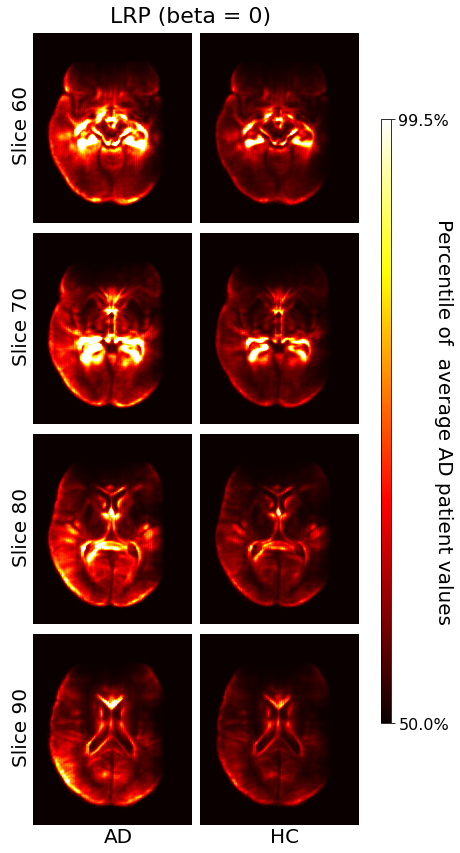

In [15]:
fig, axes = plt.subplots(4, 2, figsize=(6, 12), sharey=True, sharex=True)
vmin, vmax = 50, 99.5

for ax, idx in zip(axes[:, 0], [60, 70, 80, 90]):
    ax.text(-25, 140, "Slice " + str(idx), rotation="vertical", fontsize=20)

    fig, ax, im = plot_idv_brain(mean_maps_LRP["AD"], None, mean_maps_LRP["AD"], z_idx=idx, contour_areas=[],
                                vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");
ax.text(80, -20, "AD", fontsize=20)

for ax, idx in zip(axes[:, 1], [60, 70, 80, 90]):

    fig, ax, im = plot_idv_brain(mean_maps_LRP["HC"], None, mean_maps_LRP["AD"], z_idx=idx, contour_areas=[],
                                vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");

ax.text(80, -20, "HC", fontsize=20)
    
fig.tight_layout()
fig.subplots_adjust(right=0.8, top=0.95, hspace=0.05, wspace=0.05)
fig.suptitle("LRP (beta = 0)", fontsize=22, x=.41)

cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
cbar = fig.colorbar(im, shrink=0.5, ticks=[vmin, vmax], cax=cbar_ax)


vmin_val, vmax_val = np.percentile(mean_maps_LRP["AD"], vmin), np.percentile(mean_maps_LRP["AD"], vmax)
cbar.set_ticks([vmin_val, vmax_val])
cbar.ax.set_yticklabels(['{0:.1f}%'.format(vmin), '{0:.1f}%'.format(vmax)],
                       fontsize=16)
cbar.set_label('Percentile of  average AD patient values', rotation=270, fontsize=20)
# fig.savefig(os.path.join(data_path, "LRP_AD_HC_brain.pdf"), bbox_inches='tight')


In [16]:
import matplotlib as mpl

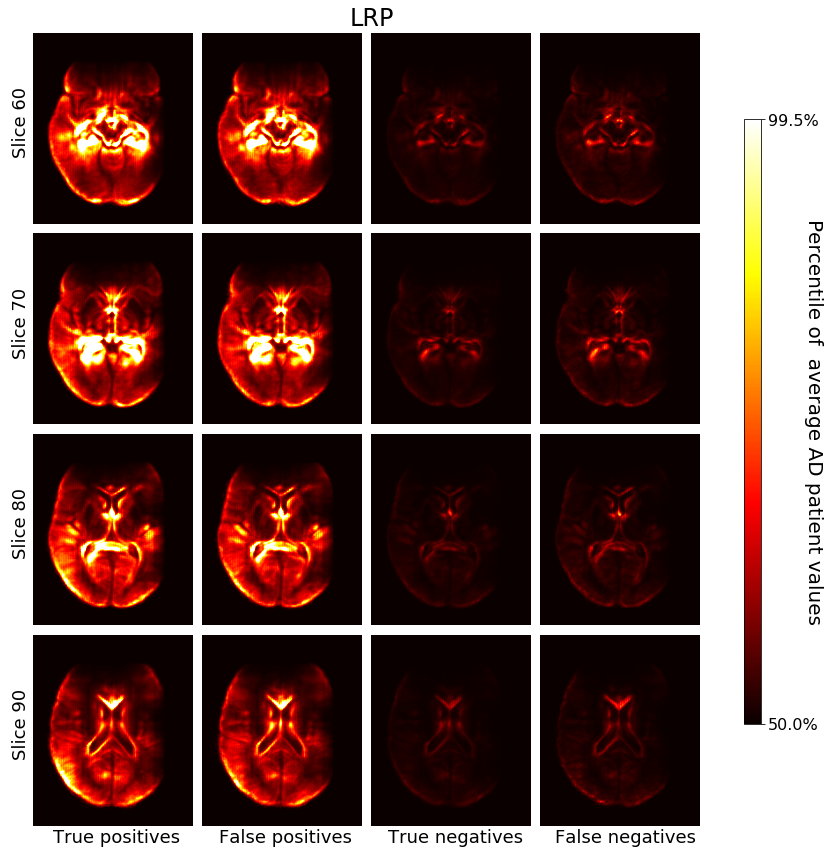

In [17]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12), sharey=True, sharex=True)
vmin, vmax = 50, 99.5

for ax, idx in zip(axes[:, 0], [60, 70, 80, 90]):
    ax.text(-25, 140, "Slice " + str(idx), rotation="vertical", fontsize=18)
    
    fig, ax, im = plot_idv_brain(mean_maps_LRP["TP"], None, mean_maps_LRP["AD"], z_idx=idx, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");

ax.text(22, -20, "True positives", fontsize=18)

for ax, idx in zip(axes[:, 1], [60, 70, 80, 90]):
    fig, ax, im = plot_idv_brain(mean_maps_LRP["FP"], None, mean_maps_LRP["AD"], z_idx=idx, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");

ax.text(18, -20, "False positives", fontsize=18)

for ax, idx in zip(axes[:, 2], [60, 70, 80, 90]):
    fig, ax, im = plot_idv_brain(mean_maps_LRP["TN"], None, mean_maps_LRP["AD"], z_idx=idx, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");
ax.text(18, -20, "True negatives", fontsize=18)

for ax, idx in zip(axes[:, 3], [60, 70, 80, 90]):
    fig, ax, im = plot_idv_brain(mean_maps_LRP["FN"], None, mean_maps_LRP["AD"], z_idx=idx, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");
ax.text(16, -20, "False negatives", fontsize=18)

fig.suptitle("LRP", fontsize=24, x=.42)
fig.tight_layout()

fig.subplots_adjust(top=0.95, right=0.8, hspace=0.05, wspace=0.05)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, shrink=0.5, ticks=[vmin, vmax], cax=cbar_ax)

vmin_val, vmax_val = np.percentile(mean_maps_LRP["AD"], vmin), np.percentile(mean_maps_LRP["AD"], vmax)
cbar.set_ticks([vmin_val, vmax_val])
cbar.ax.set_yticklabels(['{0:.1f}%'.format(vmin), '{0:.1f}%'.format(vmax)],
                        fontsize=16)
cbar.set_label('Percentile of  average AD patient values', rotation=270, fontsize=20)
# fig.savefig(os.path.join(data_path, "LRP_TP_FP_TN_FN_brain.pdf"))


# Average Heatmaps per Group and Time Point

In [4]:
with open('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/results/results_final/LRP_heatmaps_all.pkl', 'rb') as f:
    heatmaps_all = pickle.load(f)
    
with open('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/results/results_final/MCI_no_conv/LRP_heatmaps_all.pkl', 'rb') as f:
    heatmaps_mci_no_conv = pickle.load(f)
    
with open('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/results/results_final/MCI_conv/LRP_heatmaps_all.pkl', 'rb') as f:
    heatmaps_mci_conv = pickle.load(f)
 

In [5]:
ad_hc_scores = np.loadtxt('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/results/results_final/ad_scores.txt')
mci_no_conv_scores = np.loadtxt('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/results/results_final/MCI_no_conv/ad_scores.txt')
mci_conv_scores = np.loadtxt('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/results/results_final/MCI_conv/ad_scores.txt')   

In [6]:
participant_data = pd.read_csv('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/ADNI_holdout.csv', delimiter = ',')
participant_data['AD score'] = ad_hc_scores

mci_no_conv = pd.read_csv('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/ADNI_mci_no_conv.csv', delimiter = ',')
mci_no_conv['AD score'] = mci_no_conv_scores

mci_conv = pd.read_csv('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/ADNI_mci_conv.csv', delimiter = ',')
mci_conv['AD score'] = mci_conv_scores

In [7]:
idx = np.array([i[0] for i in heatmaps_all])
idx_mci_no_conv = np.array([i[0] for i in heatmaps_mci_no_conv])
idx_mci_conv = np.array([i[0] for i in heatmaps_mci_conv])

def data_group(data, group, time, list_maps, heatmaps):
    filter_group_time = np.array((data['Research Group'] == group) & (data['session'] == time))
    target = list_maps[filter_group_time]
    
    heatmaps = np.array(heatmaps)
    heatmaps = heatmaps[target]
    
    return heatmaps

def get_timepoints(time_points, data):
    avg_map = []
    for time in time_points: 
        total_heatmap = np.zeros(shape = (182, 218, 182))
        for j in data[time]: 
        #     print(len(data_ad['data_AD_screen']))
            heatmap = np.array(j[1])
            total_heatmap += heatmap
        average_heatmap = total_heatmap / len(data[time])
        avg_map.append(average_heatmap)
    return avg_map

def get_avg_ad_score(data, group, time_points, list_maps, ad_scores):
    avg_timepoints = []
    std_timepoints = []
    scores_list = []
    scores = np.array(ad_scores)
    for time in time_points: 
        filter_group_time = np.array((data['Research Group'] == group) & (data['session'] == time))
        target = list_maps[filter_group_time]

        scores_group = scores[target]
        avg = sum(scores_group) / len(scores_group)
        std = np.std(scores_group)
        
        avg_timepoints.append(avg)
        std_timepoints.append(std)
        scores_list.append([scores_group])
        
    return np.array(avg_timepoints), np.array(std_timepoints), np.array(scores_list)
    

In [8]:
time_points = ['screen', 'month06', 'month12', 'month24']

data_ad = {}
for time_point in time_points:
    data_ad['{}'.format(time_point)] = data_group(participant_data, 'AD', time_point, idx, heatmaps_all)
    
data_hc = {}
for time_point in time_points: 
    data_hc['{}'.format(time_point)] = data_group(participant_data, 'CN', time_point, idx, heatmaps_all)
    
data_mci_no_conv = {}
for time_point in time_points: 
    data_mci_no_conv['{}'.format(time_point)] = data_group(mci_no_conv, 'MCI', time_point, idx_mci_no_conv, heatmaps_mci_no_conv)
    
data_mci_conv = {}
for time_point in time_points: 
    data_mci_conv['{}'.format(time_point)] = data_group(mci_conv, 'MCI', time_point, idx_mci_conv, heatmaps_mci_conv)

In [9]:
all_avg_ad = get_timepoints(time_points, data_ad)
all_avg_hc = get_timepoints(time_points, data_hc)
all_avg_mci_no_conv = get_timepoints(time_points, data_mci_no_conv)
all_avg_mci_conv = get_timepoints(time_points, data_mci_conv)

In [10]:
avg_ad_score, std_ad_score, list_ad = get_avg_ad_score(participant_data, 'AD', time_points, idx, ad_hc_scores)
avg_hc_score, std_hc_score, list_hc = get_avg_ad_score(participant_data, 'CN', time_points, idx, ad_hc_scores)
avg_mci_no_conv_score, std_mci_no_conv_score, list_mci_no_conv = get_avg_ad_score(mci_no_conv, 'MCI', time_points, idx_mci_no_conv, mci_no_conv_scores)
avg_mci_conv_score, std_mci_conv_score, list_mci_conv = get_avg_ad_score(mci_conv, 'MCI', time_points, idx_mci_conv, mci_conv_scores)

In [11]:
reference_map = sum(all_avg_ad) / len(all_avg_ad) 

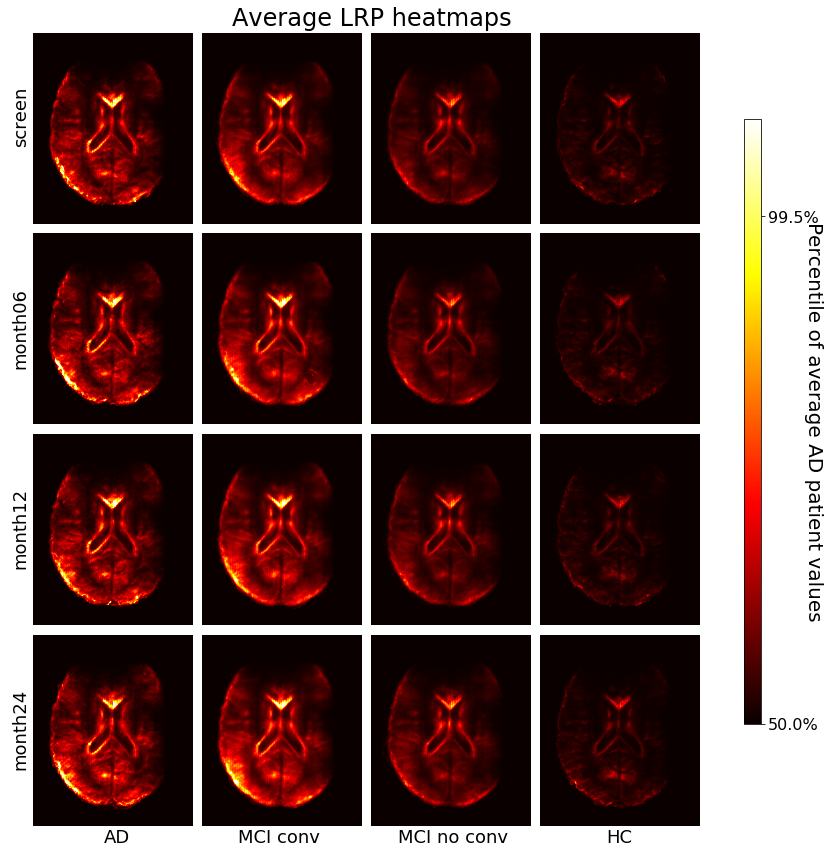

In [26]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12), sharey=True, sharex=True)
vmin, vmax = 50, 99.5

for ax, idx in zip(axes[:, 0], [(0, 'screen'), (1, 'month06'), (2,'month12'), (3, 'month24')]):
    ax.text(-25, 140, str(idx[1]), rotation="vertical", fontsize=18)
    
    fig, ax, im = plot_idv_brain(all_avg_ad[idx[0]], None, reference_map, z_idx=90, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");

ax.text(80, -20, "AD", fontsize=18)

for ax, idx in zip(axes[:, 1], [(0, 'screen'), (1, 'month06'), (2,'month12'), (3, 'month24')]):
    
    fig, ax, im = plot_idv_brain(all_avg_mci_conv[idx[0]], None, reference_map, z_idx=90, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");

ax.text(40, -20, "MCI conv", fontsize=18)

for ax, idx in zip(axes[:, 2], [(0, 'screen'), (1, 'month06'), (2,'month12'), (3, 'month24')]):
    
    fig, ax, im = plot_idv_brain(all_avg_mci_no_conv[idx[0]], None, reference_map, z_idx=90, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");

ax.text(30, -20, "MCI no conv", fontsize=18)

for ax, idx in zip(axes[:, 3], [(0, 'screen'), (1, 'month06'), (2,'month12'), (3, 'month24')]):
    
    fig, ax, im = plot_idv_brain(all_avg_hc[idx[0]], None, reference_map, z_idx=90, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");

ax.text(75, -20, "HC", fontsize=18)

fig.suptitle("Average LRP heatmaps", fontsize=24, x=.42)
fig.tight_layout()

fig.subplots_adjust(top=0.95, right=0.8, hspace=0.05, wspace=0.05)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, shrink=0.5, ticks=[vmin, vmax], cax=cbar_ax)

vmin_val, vmax_val = np.percentile(mean_maps_LRP["AD"], vmin), np.percentile(mean_maps_LRP["AD"], vmax)
cbar.set_ticks([vmin_val, vmax_val])
cbar.ax.set_yticklabels(['{0:.1f}%'.format(vmin), '{0:.1f}%'.format(vmax)],
                        fontsize=16)
cbar.set_label('Percentile of average AD patient values', rotation=270, fontsize=20)
# fig.savefig(os.path.join(data_path, "AD_HC_MCI_brain.pdf"))



## AD scores per group and time point

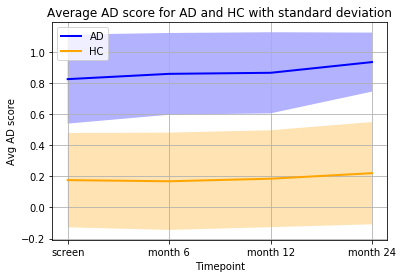

In [27]:
x = [1, 2, 3, 4]

fig, ax = plt.subplots(1)
ax.plot(x, avg_ad_score, lw=2, label='AD', color='blue')
ax.plot(x, avg_hc_score, lw=2, label='HC', color='orange')
ax.fill_between(x, avg_ad_score+std_ad_score, avg_ad_score-std_ad_score, facecolor='blue', alpha=0.3)
ax.fill_between(x, avg_hc_score+std_hc_score, avg_hc_score-std_hc_score, facecolor='orange', alpha=0.3)
ax.set_title(r'Average AD score for AD and HC with standard deviation')
ax.legend(loc='upper left')
ax.set_xlabel('Timepoint')
ax.set_ylabel('Avg AD score')
plt.xticks(x, ('screen', 'month 6', 'month 12', 'month 24'))
ax.grid()

# fig.savefig(os.path.join(data_path, "AD_HC_scores.pdf"))

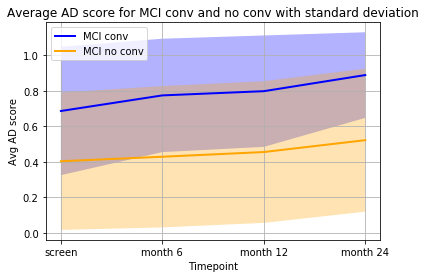

In [28]:
fig, ax = plt.subplots(1)
ax.plot(x, avg_mci_conv_score, lw=2, label='MCI conv', color='blue')
ax.plot(x, avg_mci_no_conv_score, lw=2, label='MCI no conv', color='orange')
ax.fill_between(x, avg_mci_conv_score+std_mci_conv_score, avg_mci_conv_score-std_mci_conv_score, facecolor='blue', alpha=0.3)
ax.fill_between(x, avg_mci_no_conv_score+std_mci_no_conv_score, avg_mci_no_conv_score-std_mci_no_conv_score, facecolor='orange', alpha=0.3)
ax.set_title(r'Average AD score for MCI conv and no conv with standard deviation')
ax.legend(loc='upper left')
ax.set_xlabel('Timepoint')
ax.set_ylabel('Avg AD score')
plt.xticks(x, ('screen', 'month 6', 'month 12', 'month 24'))
ax.grid()

fig.savefig(os.path.join(data_path, "MCI_conv_scores.pdf"))

In [12]:
from scipy import stats

In [13]:
stats.ttest_ind(list_mci_conv[0][0], list_mci_no_conv[0][0], equal_var = False)

Ttest_indResult(statistic=6.547753820251336, pvalue=3.321679497233108e-10)

In [79]:
# plt.plot(data_ad['screen'])
def get_scores_group(data, group, time, list_maps, ad_scores):
    list_scores = []
    scores = np.array(ad_scores)
    for time in time_points: 
        filter_group_time = np.array((data['Research Group'] == group) & (data['session'] == time))
        target = list_maps[filter_group_time]

        scores_group = scores[target]
        list_scores.append(np.array(scores_group))
    return list_scores

In [80]:
idx = np.array([i[0] for i in heatmaps_all])
idx_mci_no_conv = np.array([i[0] for i in heatmaps_mci_no_conv])
idx_mci_conv = np.array([i[0] for i in heatmaps_mci_conv])

In [81]:
scores_ad = get_scores_group(participant_data, 'AD', time_points, idx, ad_hc_scores)
scores_hc = get_scores_group(participant_data, 'CN', time_points, idx, ad_hc_scores)
scores_mci_no_conv = get_scores_group(mci_no_conv, 'MCI', time_points, idx_mci_no_conv, mci_no_conv_scores)
scores_mci_conv = get_scores_group(mci_conv, 'MCI', time_points, idx_mci_conv, mci_conv_scores)

In [60]:
scores_ad_hc = np.concatenate((np.array(scores_ad), np.array(scores_hc)), axis = 1)
# scores_mci = np.concatenate((np.array(scores_mci_no_conv), np.array(scores_mci_conv)), axis = 1)
print(scores_ad_hc.shape)

(4, 46)


## Statistics on AD scores

In [61]:
from scipy import stats

In [101]:
alpha = 0.05
for score in scores_ad_hc: 
    k2, p = stats.normaltest(score)
    if p < alpha: 
        print('\nThe data does not come from a normal distribution')
    else: 
        print('Data comes from a normal distribution')
    stat, p = stats.mannwhitneyu(score[:len(scores_ad)], score[len(scores_ad):], alternative = 'greater')
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')


The data does not come from a normal distribution
Statistics=131.000, p=0.035
Different distribution (reject H0)

The data does not come from a normal distribution
Statistics=122.000, p=0.072
Same distribution (fail to reject H0)

The data does not come from a normal distribution
Statistics=117.000, p=0.103
Same distribution (fail to reject H0)

The data does not come from a normal distribution
Statistics=134.000, p=0.027
Different distribution (reject H0)


In [100]:
for i, score_conv in enumerate(scores_mci_conv):
    score = scores_mci_no_conv[i]
    scores = np.concatenate((score, score_conv))
    k2, p = stats.normaltest(scores)
    if p < alpha: 
        print('\nThe data does not come from a normal distribution')
    else: 
        print('Data comes from a normal distribution')
    stat, p = stats.mannwhitneyu(score_conv, score, alternative = 'greater')
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')


The data does not come from a normal distribution
Statistics=17164.000, p=0.000
Different distribution (reject H0)

The data does not come from a normal distribution
Statistics=11941.000, p=0.000
Different distribution (reject H0)

The data does not come from a normal distribution
Statistics=13037.000, p=0.000
Different distribution (reject H0)

The data does not come from a normal distribution
Statistics=7804.000, p=0.000
Different distribution (reject H0)


In [105]:
scores_ad_all = np.array(scores_ad).flatten()
scores_hc_all = np.array(scores_hc).flatten()

stat, p = stats.mannwhitneyu(scores_ad_all, scores_hc_all, alternative = 'greater')
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=7492.000, p=0.000
Different distribution (reject H0)


In [123]:
scores_mci_conv_all = np.concatenate((scores_mci_conv[0], scores_mci_conv[1], scores_mci_conv[2], scores_mci_conv[3]))
scores_mci_no_conv_all = np.concatenate((scores_mci_no_conv[0], scores_mci_no_conv[1], scores_mci_no_conv[2], scores_mci_no_conv[3]))

In [124]:
scores_ad_all = np.array(scores_ad).flatten()
scores_hc_all = np.array(scores_hc).flatten()

stat, p = stats.mannwhitneyu(scores_mci_conv_all, scores_mci_no_conv_all, alternative = 'greater')
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=198485.000, p=0.000
Different distribution (reject H0)
